In [47]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torchvision.datasets.folder import default_loader

import math
import matplotlib.pyplot as plt

import os

import numpy as np

# Transformando nossos .jpg em tensores que vão virar nosso conjunto de treino :

In [77]:
# Caminho para a pasta com as imagens
path = "/Users/matheus/Documents/faculdade/Intro. ML/Trabalho Final - ML/database"

# Transformações para aplicar às imagens
transform = transforms.Compose([
    # transforms.Resize((128, 128)),  # Redimensiona as imagens para 128x128 pixels
    transforms.ToTensor(), # Converte as imagens em tensores
])

files_list = os.listdir(path)
train_data_length = len(files_list)

# criando os tensores para armazenar as imagens e rótulos
train_data = torch.zeros(train_data_length, 3, 128, 128) # 3 canais de cores, 128x128 pixels
train_labels = torch.zeros(train_data_length)

# Percorre os arquivos na pasta de imagens
for filename in os.listdir(path):  # os.listdir(data_folder) retorna uma lista com todos arquivos que estão no path 
    if filename.endswith(".jpg"):
        # Carrega a imagem usando o loader padrão
        img_path = os.path.join(path, filename)
        img = default_loader(img_path)

        # Aplica as transformações à imagem
        img = transform(img)

        # Salva a imagem no tensor train_data
        index = files_list.index(filename)
        train_data[index] = img

train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

# Cria um DataLoader para carregar os dados em lotes durante o treinamento
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=32, shuffle=True
    )


In [78]:
# preparando terreno para usarmos GPU quando possível (se não, usaremos CPU)
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Aqui estão exemplos de imagens que estão no nosso train_set :

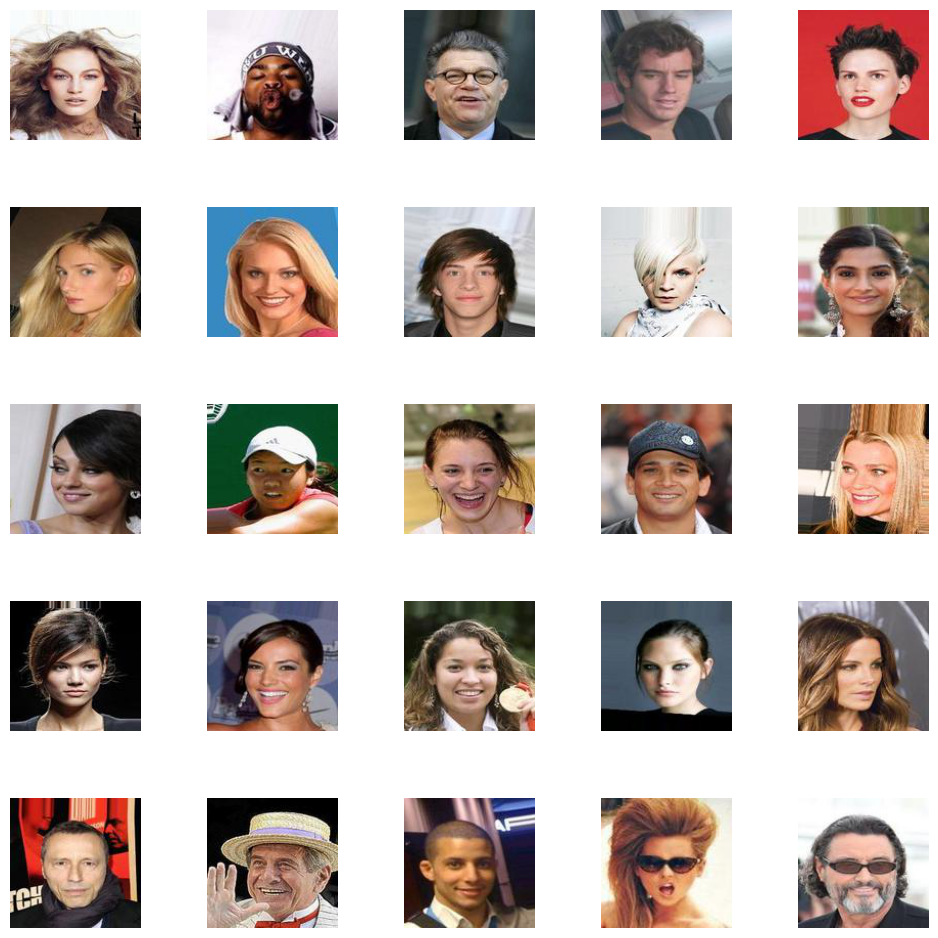

In [103]:
real_samples, labels = next(iter(train_loader))

n = 5
# Exibir as imagens
fig, axs = plt.subplots(n, n, figsize=(10, 10))
fig.tight_layout()

for i in range(n**2):
    row = i // n
    col = i % n
    img = real_samples[i].permute(1, 2, 0)  # Reorganizar as dimensões do tensor
    axs[row, col].imshow(img)
    axs[row, col].axis("off")

plt.show()

# Criando as classes que representam as redes Generativas e Discriminativas

In [94]:
dimensao = 128
numero_de_pixels = dimensao * dimensao

#help
class Discriminator(nn.Module):
    """
    Implementa o discriminador da rede GAN que herda da classe nn.Module que tem já implementado algumas funcionalidades convencionais.
    Rede neural com camada inicial de tamanho 3*128*128 ( canais de entrada de cor * dimensão * dimensão ) e camada final de tamanho 1
    ( saída binária ) com função de ativação sigmoid.
    
    """
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3 * 128 * 128, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x) -> torch.Tensor:
        x = x.view(x.size(0), 3 * 128 * 128)
        output = self.model(x)
        return output

In [95]:
discriminator = Discriminator().to(device=device)

In [96]:
class Generator(nn.Module):
    """
    Implementa o gerador da rede GAN que herda da classe nn.Module que tem já implementado algumas funcionalidades convencionais.
    Rede neural com camada inicial de tamanho 100 ( tamanho do vetor de entrada ) e camada final de tamanho 3*128*128 
    ( canais de saída de cor * dimensão * dimensão )

    """

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3 * 128 * 128),
            nn.Tanh(),
        )

    def forward(self, x) -> torch.Tensor:
        output = self.model(x)
        output = output.view(x.size(0), 3, 128, 128)
        return output

generator = Generator().to(device=device)

# Escolhendo os parâmetros de treinamento

In [97]:
lr = 0.0001 # learning rating 
num_epochs = 50 # número de épocas ( iterações )
loss_function = nn.BCELoss() # função de perda ( binary cross entropy loss )

# Otimizadores para o gerador e o discriminador, seguindo o algoritmo Adam
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [101]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        real_samples = real_samples.to(device=device)
        batch_size = real_samples.shape[0]  # Obter o tamanho atual do lote
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        all_samples = torch.cat((real_samples, generated_samples))

        # Treinamento do discriminador
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Dados para o treinamento do gerador
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        # Treinamento do gerador
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Exibir as perdas
        if n == len(train_loader) - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")


Epoch: 0 Loss D.: 0.22610682249069214
Epoch: 0 Loss G.: 2.2678730487823486
Epoch: 1 Loss D.: 0.3377537727355957
Epoch: 1 Loss G.: 1.5565592050552368
Epoch: 2 Loss D.: 0.3477526009082794
Epoch: 2 Loss G.: 1.2834173440933228
Epoch: 3 Loss D.: 0.2136397510766983
Epoch: 3 Loss G.: 2.133589029312134
Epoch: 4 Loss D.: 0.4484215974807739
Epoch: 4 Loss G.: 2.1285226345062256
Epoch: 5 Loss D.: 0.3646978437900543
Epoch: 5 Loss G.: 1.7438983917236328
Epoch: 6 Loss D.: 0.518949568271637
Epoch: 6 Loss G.: 1.784925937652588
Epoch: 7 Loss D.: 0.5788515210151672
Epoch: 7 Loss G.: 1.0182865858078003
Epoch: 8 Loss D.: 0.45287343859672546
Epoch: 8 Loss G.: 1.2528923749923706
Epoch: 9 Loss D.: 0.6314206719398499
Epoch: 9 Loss G.: 0.7536806464195251
Epoch: 10 Loss D.: 0.6248707175254822
Epoch: 10 Loss G.: 0.8109415173530579
Epoch: 11 Loss D.: 0.732515811920166
Epoch: 11 Loss G.: 0.7022161483764648
Epoch: 12 Loss D.: 0.651456892490387
Epoch: 12 Loss G.: 0.7477099299430847
Epoch: 13 Loss D.: 0.73272830247879

In [102]:
output_dir = "generated_images"
os.makedirs(output_dir, exist_ok=True)

num_samples = 10  # Número de amostras a serem geradas

generator.eval()  # Coloque o gerador no modo de avaliação
latent_samples = torch.randn(num_samples, 100).to(device=device)  # Gere amostras latentes aleatórias
generated_samples = generator(latent_samples)  # Gere as amostras

# Converta as amostras geradas em imagens
generated_images = generated_samples.cpu().detach()

# Salve as imagens geradas
for i in range(num_samples):
    img = generated_images[i].squeeze().permute(1, 2, 0).numpy()
    img = (img + 1) / 2  # Reescala para o intervalo [0, 1]
    save_path = os.path.join(output_dir, f"generated_image_{i}.png")
    plt.imsave(save_path, img)